<a href="https://colab.research.google.com/github/evan-cao-wb/Data-Analytics/blob/master/The_analytics_of_Lending_Club.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Load Libraries

In [ ]:
import os,gc
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error,r2_score,roc_auc_score,roc_curve



import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_path = "/content/drive/My Drive/Github/Data/"
loan = pd.read_csv(os.path.join(data_path,"loan.csv"),low_memory=False)

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           887379 non-null  int64  
 1   member_id                    887379 non-null  int64  
 2   loan_amnt                    887379 non-null  float64
 3   funded_amnt                  887379 non-null  float64
 4   funded_amnt_inv              887379 non-null  float64
 5   term                         887379 non-null  object 
 6   int_rate                     887379 non-null  float64
 7   installment                  887379 non-null  float64
 8   grade                        887379 non-null  object 
 9   sub_grade                    887379 non-null  object 
 10  emp_title                    835917 non-null  object 
 11  emp_length                   842554 non-null  object 
 12  home_ownership               887379 non-null  object 
 13 

This dataset mainly include 6 aspects of clients:
  - **Basic loan info**: loan_id, member_id, loan_amount, term, issue_date, loan_status
  - **Credit info**: sub_grad(credit grade), interest
  - **Individual info**: ownership, employer_title, employee_year, annual_income
  - **Other info**: Purpose...
  - **Geographic info**: zip_code, address_states...
  - **Public record info**: Month_since_last_decline, inquiry over past 60 days

In [ ]:
# Check if there are duplicate ids/member_ids
loan.duplicated(subset=['id','member_id'] ).any() # False


# Sort data by issue date
loan.sort_values("issue_d",ascending=True,inplace=True)
loan = loan.reset_index(drop=True)

default_loan_list = ['Charged Off',"Late (31-120 days)","Late (16-30 days)",'Default',"Does not meet the credit policy. Status:Charged Off","In Grace Period" ]

loan['loan_condition'] = np.where(loan['loan_status'].isin(default_loan_list),"non-performing","performing")
loan['loan_condition'] = np.where(loan['loan_status']=="Current","on-going",loan['loan_condition'])

# Transform issue_id to datetime type and check if there is any null value
loan['issue_d'] = pd.to_datetime(loan['issue_d'])
loan['issue_d'].isnull().any() # False

loan['year'] = loan['issue_d'].dt.year

# Create region based on states
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def get_the_region(state):
  if state in west:
      return 'West'
  elif state in south_west:
      return 'SouthWest'
  elif state in south_east:
      return 'SouthEast'
  elif state in mid_west:
      return 'MidWest'
  elif state in north_east:
      return 'NorthEast'

loan['region'] = loan['addr_state'].apply(get_the_region)



non_performing_l = loan[loan['loan_condition'] == "non-performing"]

In [ ]:
print(f"There are total {len(loan.columns)} columns in dataset.")

There are total 77 columns in dataset.


# Task 1: Data Analytics

- Questions:
  - Overview about operation analysis of lending club
    - How does the number of transactions change over these years?
    - How do the loan amounts change over these years?
    - How does the number of clients change over these years?
    - How does the loan amount per person change over these years?
  - The total number of default loan every year? And how about non-performing loan ratio?
  - What kind of loan amount is most popular? And the clients how apply this kind of loan will mostly select what term to payback?
  - The range of interest?
  - Does the risk model work according to this dataset? What kind of credit will have most default loan?
  - What kind of working year is good/bad for loan application?
  - What kind of relationship is there between annual income and non-performing loan ratio?
  - What kind of purpose mostly/least cause default loan?
  - What kind of purpose will be a risk factor in the loan cases?
  - What's the most common Purpose that a client request a loan?
  - What's the distribution of Loan Amount/Interest/Loan Status?

## Q1:The analysis of Lending Club operation:

### Q1.1 & Q1.2: How does the number of loan cases change over these years? & How do the amounts of loan cases change over these years? 

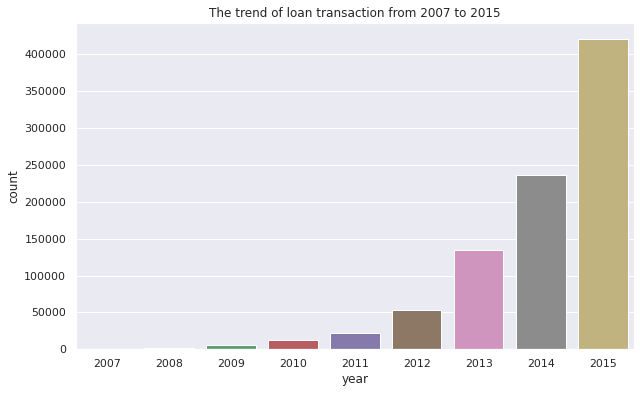

In [ ]:
# The trend of loan transaction from 2007 to 2015

plt.figure(figsize=(10,6))
sns.countplot("year",data=loan)
plt.title("The trend of loan transaction from 2007 to 2015")
plt.show()

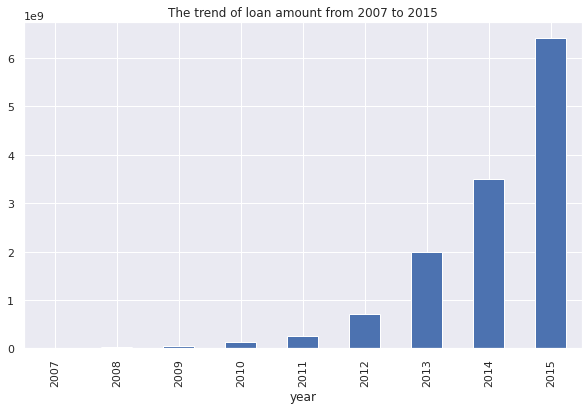

In [ ]:
# The trend of loan amount change from 2007 to 2015

plt.figure(figsize=(10,6))
loan.groupby('year')['loan_amnt'].sum().plot.bar()
plt.title("The trend of loan amount from 2007 to 2015")
plt.show()

From above two graphs, we can find the number of clients and total loan amount are growing year by year. And during these years, there is no clinets who apply for loan more then twice. We think due to the accumulation of credit of Lending Club, the increasing number of clients bring the increment of transactions and loan amount.

Although there is an increasing profit in Lending Club, we still wonder how default loan impact the profitability of this platform.

### Q1.3: How does the number of clients change over these years?

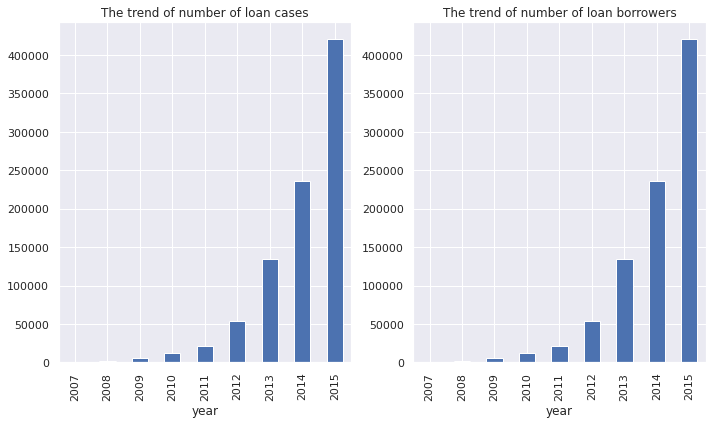

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,6))

loan.groupby('year')['id'].count().plot.bar(ax=ax[0])
ax[0].set_title("The trend of number of loan cases",fontsize=12)

loan.groupby('year')['member_id'].count().plot.bar(ax=ax[1])
ax[1].set_title("The trend of number of loan borrowers",fontsize=12)

plt.tight_layout()
plt.show()

There is a growing trend over these year. It exhibits that lending club attracted a lot of clients becuase of its good reputation. But we should notice that this trend was growing exponentially.

### Q1.4: How does the loan amount per person change over these years?

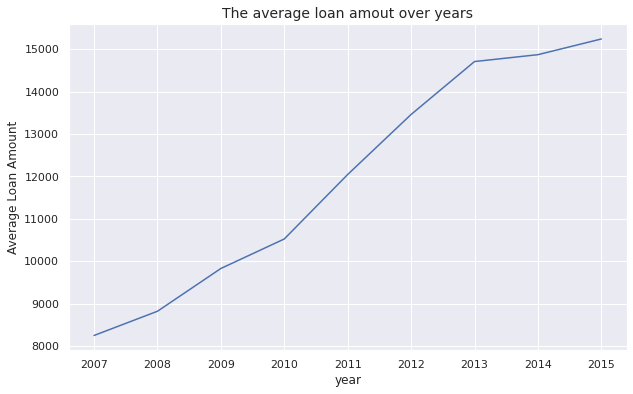

In [ ]:
plt.figure(figsize=(10,6))

loan.groupby("year")['loan_amnt'].mean().plot.line()

plt.title("The average loan amout over years",fontsize=14)
plt.ylabel("Average Loan Amount")

plt.show()

Although the trend still keep increasing, its pace become slowly.

In this step, we have a overview on Lending club operation. To improve its profitability, we should concetrate on two things: **reducing the loss**, **increasing the profit**

### Q1.5: The distribution of loan amount

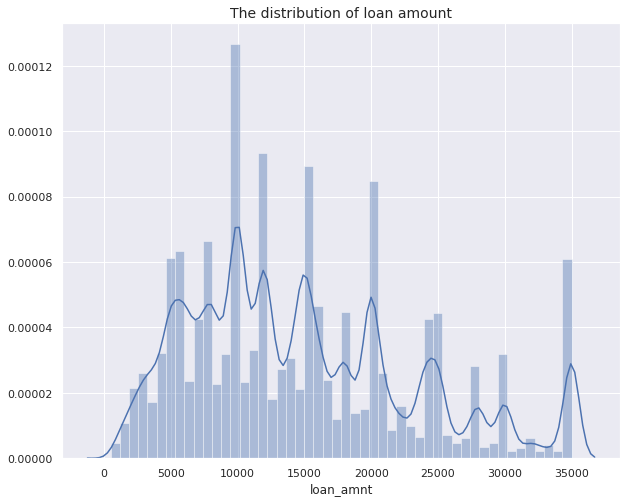

In [ ]:
plt.figure(figsize=(10,8))
sns.distplot(loan['loan_amnt'])
plt.title("The distribution of loan amount",fontsize=14)
plt.show()

In [ ]:
loan['loan_amnt'].describe()

count    887379.000000
mean      14755.264605
std        8435.455601
min         500.000000
25%        8000.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

The average is around 15k dollars, minimum value is 500 dollars and maximum value is 35k dollars. The distribution is kind of right-skwed. **That means the lending club mainly focus on small loan business.**

## Q2: The analysis of Default Loan (reducing the loss)

In [ ]:
# Display the kinds of default loan
loan['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [ ]:
default_loan_list = ['Charged Off',"Late (31-120 days)","Late (16-30 days)",'Default',"Does not meet the credit policy. Status:Charged Off","In Grace Period" ]


print(f"During 2007 to 2015, total number of loan is {loan.shape[0]}")
print(f"During 2007 to 2015, non-performing loan ratio is {round(non_performing_l.shape[0]/ loan.shape[0],3)}")


During 2007 to 2015, total number of loan is 887379
During 2007 to 2015, non-performing loan ratio is 0.076


### Q2.1: What is the proportion of "on-going", "performing" and "non-performing" loan?

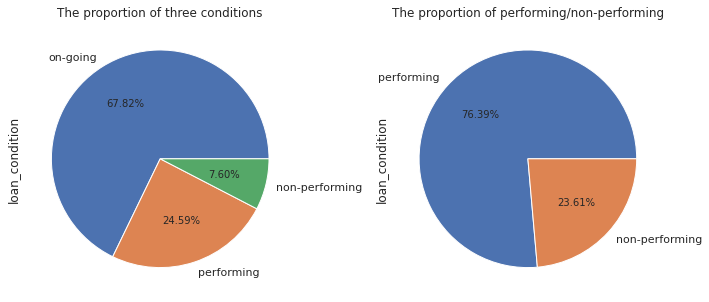

In [ ]:
fig,ax =plt.subplots(1,2,figsize=(10,8))


loan['loan_condition'].value_counts().plot.pie(autopct="%0.2f%%",ax=ax[0])
ax[0].set_title("The proportion of three conditions")

loan[loan['loan_condition']!="on-going" ]['loan_condition'].value_counts().plot.pie(autopct="%0.2f%%",ax=ax[1])
ax[1].set_title("The proportion of performing/non-performing")
plt.tight_layout()
plt.show()

In the first graph, non-performing loan ratio is 7.82%. This ratio is not so good because most commercial banks are trying to narrow this ratio to 1%-2%. And we have to take on-going loan into consideration. It is likely that more and more default loan will appear in these on-going cases. So, this ratio is likely to be higher in the future.

In the second graph, we can clearly find that non-performing loans have nearly 1/4 proportion. It will cost lots of loss. We are going to explore some insights behind this phenomenon.


### Q 2.2: The trend of three loans by years

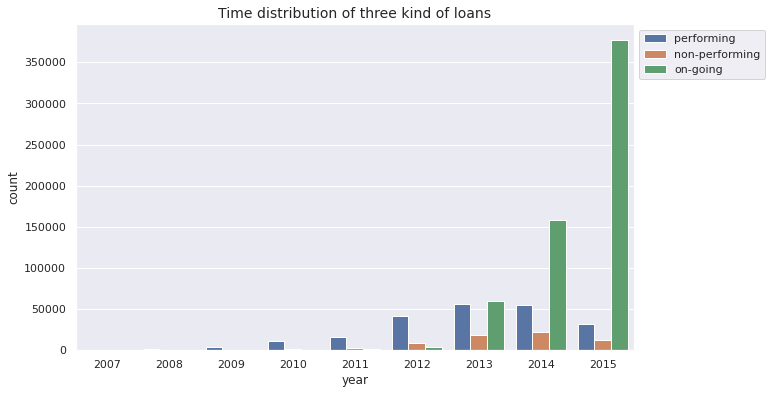

In [ ]:
# Explore the time distribution of default loan
plt.figure(figsize=(10,6))
g = sns.countplot(x="year",hue="loan_condition",data=loan)



plt.title("Time distribution of three kind of loans",fontsize=14)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

### Q 2.3: How does the number loan and default loan ratio change over these years?

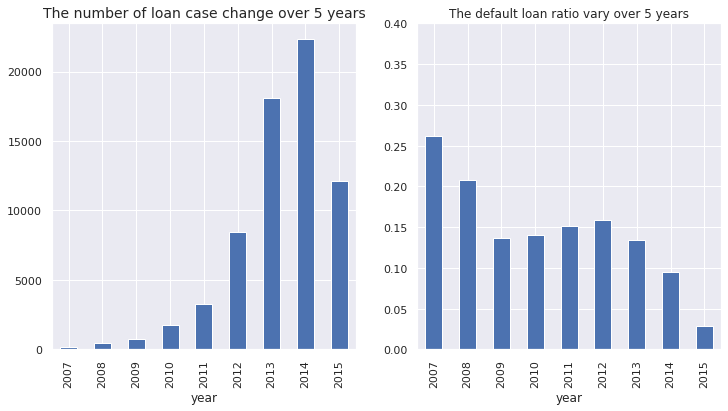

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

non_performing_l.groupby(["year"])['id'].count().plot.bar(ax=ax[0])

ax[0].set_title("The number of loan case change over 5 years",fontsize=14)
#ax[0].set_xticks(loan['year'].sort_values() ,rotation=0)

non_performing_ratio = non_performing_l.groupby('year')['id'].count()/loan.groupby('year')['id'].count()
non_performing_ratio.plot(kind='bar',ax=ax[1])
ax[1].set_title("The default loan ratio vary over 5 years")
ax[1].set_yticks(np.arange(0,0.45,0.05))

plt.show()

With increment of loan application, the default loan ratio even decrease after 2012. It displays Lending Club has a good performance in controling loan risk. We are going to explore some insights behind this phenomenon.

## Q3: The analysis of Clients

### Q3.1: What amount range is the most clients likely to select?

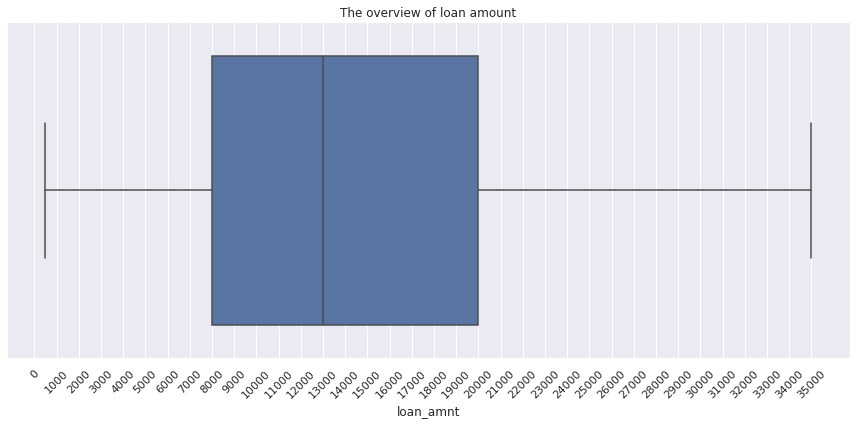

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(x='loan_amnt',data=loan)

plt.title("The overview of loan amount")
plt.xticks(np.arange(0,loan['loan_amnt'].max()+1000,1000),rotation=45)
plt.tight_layout()
plt.show()

Clients are likely to borrow money which is below 35000 dollars and generally select 36 months to payback.

### Q3.2: What kind of term is the most popular?


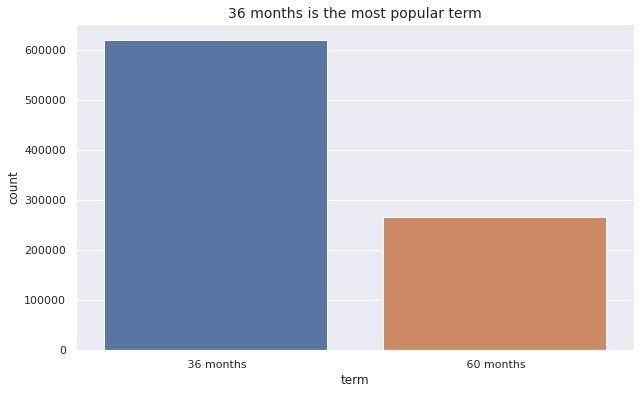

In [ ]:
plt.figure(figsize=(10,6))

sns.countplot(x = 'term',data = loan)
plt.title("36 months is the most popular term",fontsize=14)

plt.show()

The investor prefer 36 months because they think longer investing term bring the higher risk. **Thus, most loan businesses are likely to select 36 terms as loan period.**

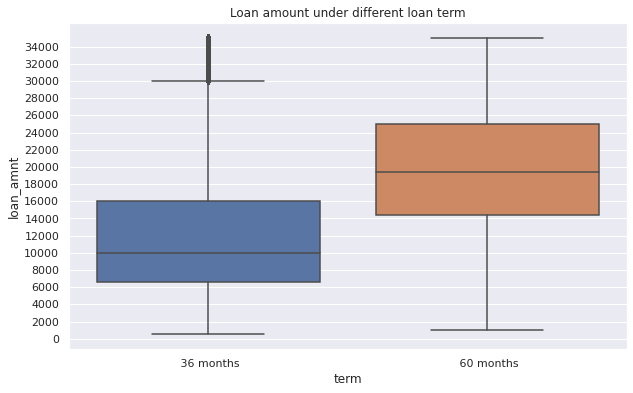

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='term',y='loan_amnt',data=loan)
plt.title("Loan amount under different loan term")
plt.yticks(np.arange(0,36000,2000))
plt.show()

**The loan amounts in 60 months are higher than 36 months. And 60 months loans are only for those loan whose amounts are above $14000.**

### Q3.3: The distribution of clients in these state. And what about their default loan ratio, annual income, loan amount and interest.

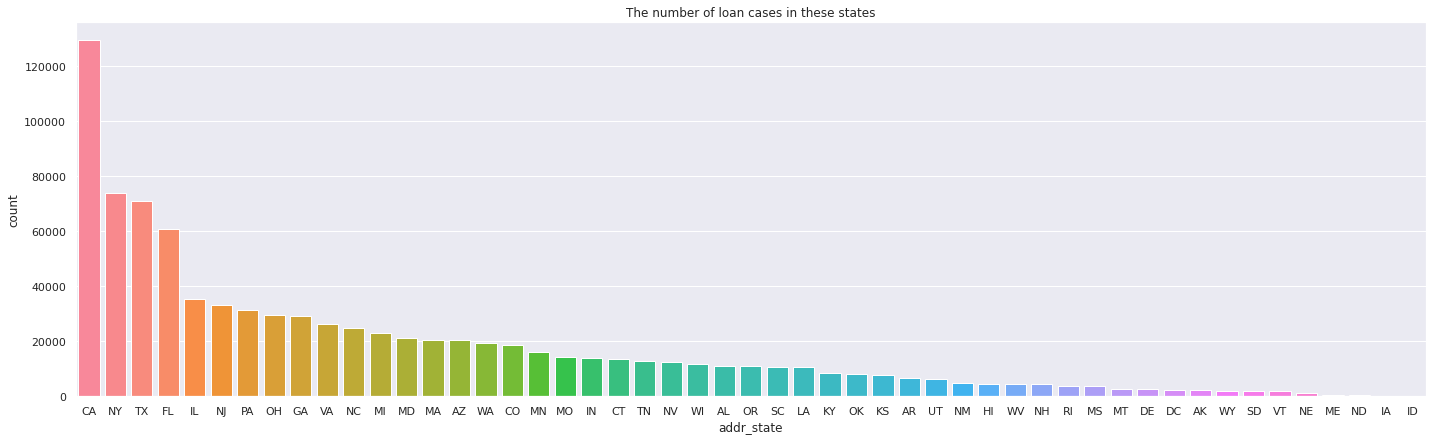

In [ ]:
plt.figure(figsize=(20,6))
g= sns.countplot(x='addr_state',data=loan,saturation=2,order=loan['addr_state'].value_counts().index)


plt.xticks(rotation=0)
plt.tight_layout()
plt.title("The number of loan cases in these states")
plt.show()

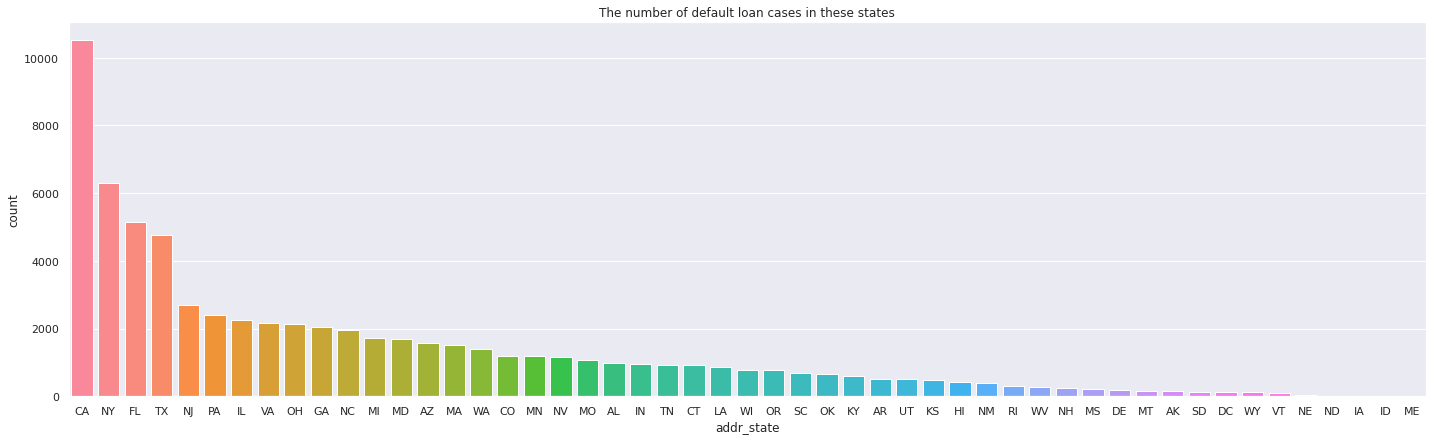

In [ ]:
plt.figure(figsize=(20,6))
g= sns.countplot(x='addr_state',data=loan[loan['loan_condition']=="non-performing"],saturation=2,order=loan[loan['loan_condition']=="non-performing"]['addr_state'].value_counts().index)


plt.xticks(rotation=0)
plt.tight_layout()
plt.title("The number of default loan cases in these states")
plt.show()

From two graphs, we find there are 6 states we should pay more attention: CA, NY,FL,TX,NJ,PA due to large number of default loan cases. And we will set two thresholds to divided these states into three groups: **High default, Medium defalut, and Low default**. Doing so will help us to identify if this clients have default loan.

In [ ]:
# Explore loan and default loan by region
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

def get_the_region(state):
  if state in west:
      return 'West'
  elif state in south_west:
      return 'SouthWest'
  elif state in south_east:
      return 'SouthEast'
  elif state in mid_west:
      return 'MidWest'
  elif state in north_east:
      return 'NorthEast'

loan['region'] = loan['addr_state'].apply(get_the_region)
non_performing_l['region'] = non_performing_l['addr_state'].apply(get_the_region)

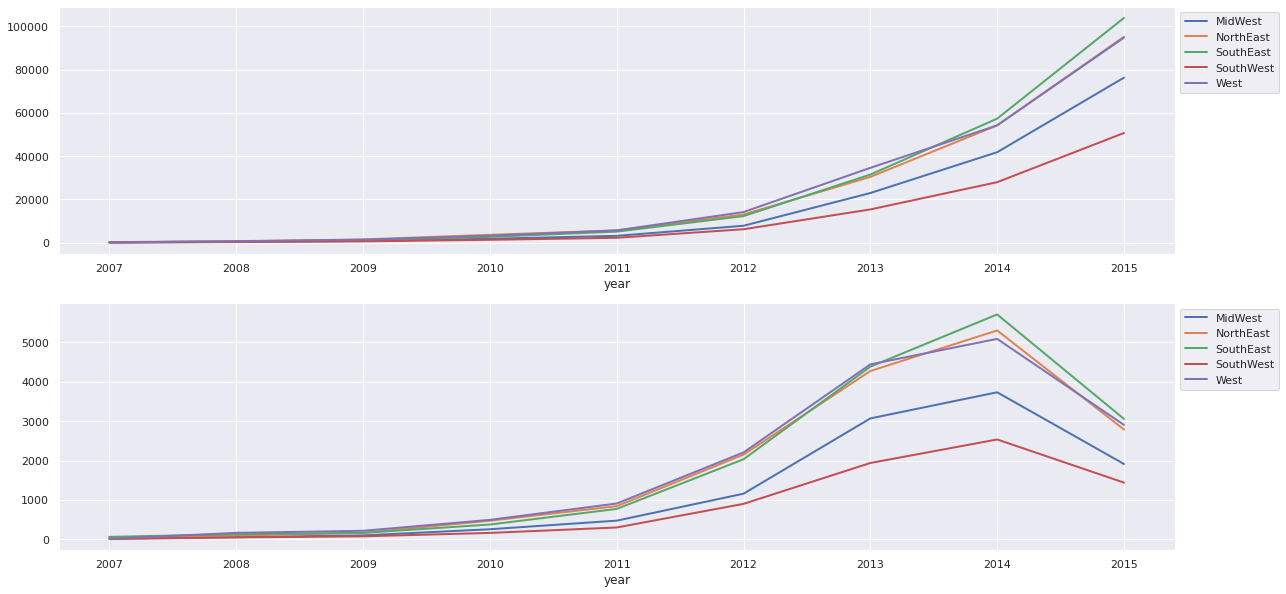

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
loan.groupby(["year",'region'])['id'].count().unstack().plot(ax = ax[0],lw=2)
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title("")

non_performing_l.groupby(["year",'region'])['id'].count().unstack().plot(ax = ax[1],lw=2)
ax[1].legend(bbox_to_anchor=(1,1))

plt.show()

There is a common trend among these states. Obviously, Lending Club upgrade its own risk-control model to curb the increment of default loan in 2014.

In [ ]:
loan['int_rate'].describe(),non_performing_l['int_rate'].describe()

(count    887379.000000
 mean         13.246740
 std           4.381867
 min           5.320000
 25%           9.990000
 50%          12.990000
 75%          16.200000
 max          28.990000
 Name: int_rate, dtype: float64, count    67429.000000
 mean        15.927657
 std          4.313284
 min          5.320000
 25%         12.990000
 50%         15.610000
 75%         18.750000
 max         28.990000
 Name: int_rate, dtype: float64)

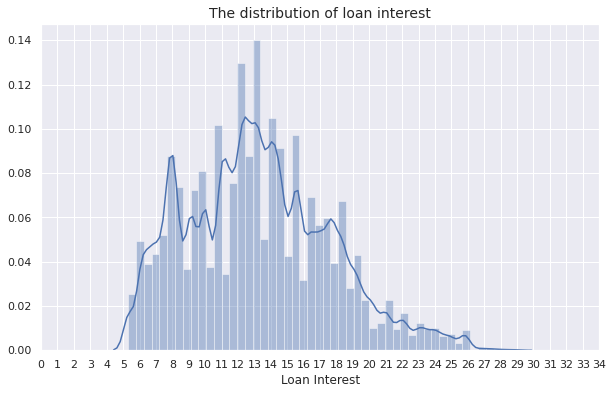

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(loan.int_rate)


plt.title("The distribution of loan interest",fontsize=14)
plt.xlabel("Loan Interest")
plt.xticks(np.arange(0,35))
plt.show()

The distribution of interest is kind of right-skewed. Most clients have the interest below 16%. The non-performing loan interest will be higher than other loan. **That means that lending club tend to lend money to those who deserve low interests.**

### Q3.4: The relationship between initial loan purpose and default condition.

Purpose is a crucial factor to determine if this loan is non-performing because it directly reflect where this money will be used. Some good purposes will put the loan principal into safety, but other nefarious intentions will make client loss most principal so that they cannot afford monthly payback.

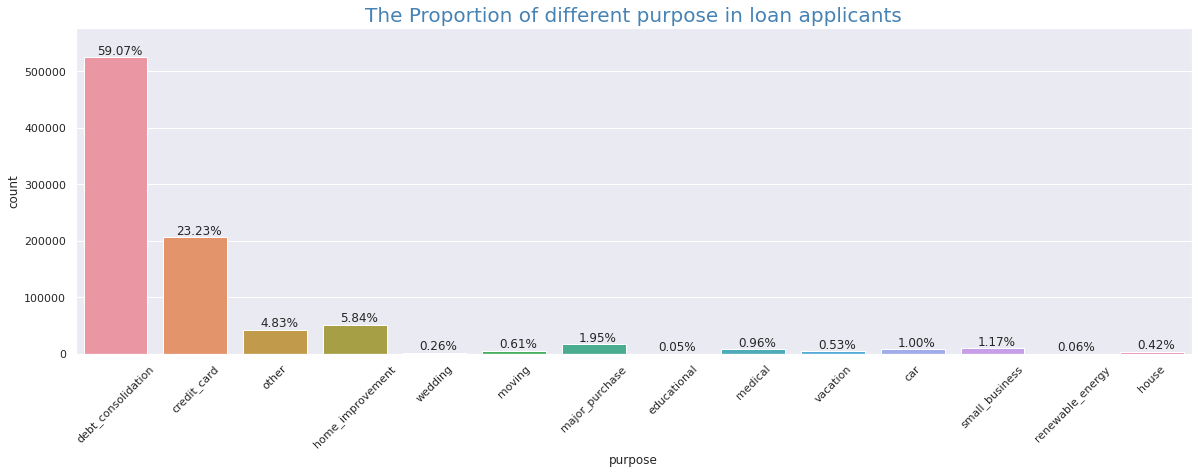

In [ ]:
plt.figure(figsize=(20,6))
g = sns.countplot(x='purpose',data=loan, orient='h')
h = []
for p in g.patches:
  g.text(p.get_x()+p.get_width()/2+0.05, p.get_height()+5000 , f"{p.get_height()/loan.shape[0]*100:2.2f}%",ha="center",fontsize=12)
  h.append(p.get_height())
g.set_ylim(0, max(h)*1.1)
g.set_xticklabels(g.get_xticklabels() ,rotation=45)
plt.title("The Proportion of different purpose in loan applicants",fontsize=20,color="steelblue")
plt.show()

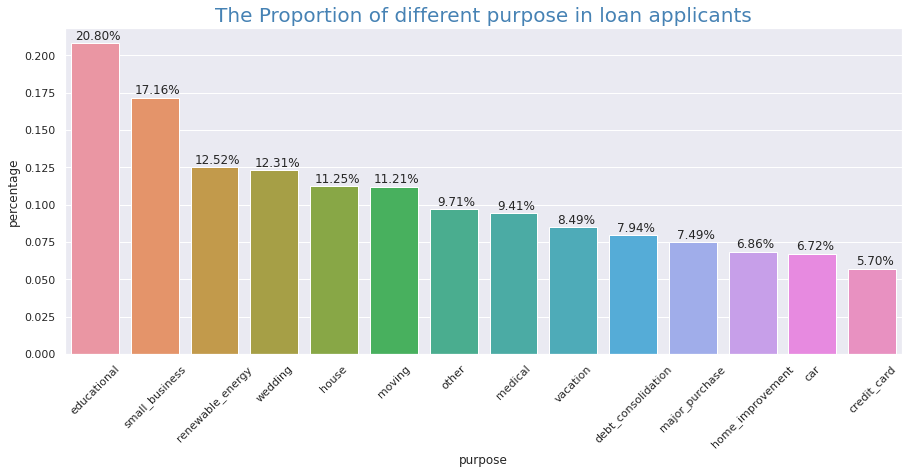

In [ ]:
purpose_df = pd.DataFrame()
p_num = []
p_list = []
for p in loan['purpose'].value_counts().index.tolist():
  p_num.append( non_performing_l[non_performing_l['purpose']==p]['id'].shape[0]/ loan[loan['purpose']==p]['id'].shape[0])
  p_list.append(p)
purpose_df['purpose'] = p_list
purpose_df['percentage'] = p_num


plt.figure(figsize=(15,6))

g = sns.barplot(x="purpose",y="percentage", data=purpose_df,order=purpose_df.sort_values(by="percentage",ascending=False)['purpose'])

for p in g.patches:
  g.text(p.get_x()+p.get_width()/2+0.05, p.get_height() +0.0025 , f"{p.get_height()*100:2.2f}%",ha="center",fontsize=12)
  

g.set_xticklabels(g.get_xticklabels() ,rotation=45)
plt.title("The Proportion of different purpose in loan applicants",fontsize=20,color="steelblue")
plt.show()



**Education, small business** and **renewable energy** are top three loan purposes. It is not surprised for us because these purpose are mostly towards young, low income/unstable income groups. So, purpose is a significant factor to decide loan approval/reject and loan interest.

### Q3.5: How home ownship does affect the loan approval?


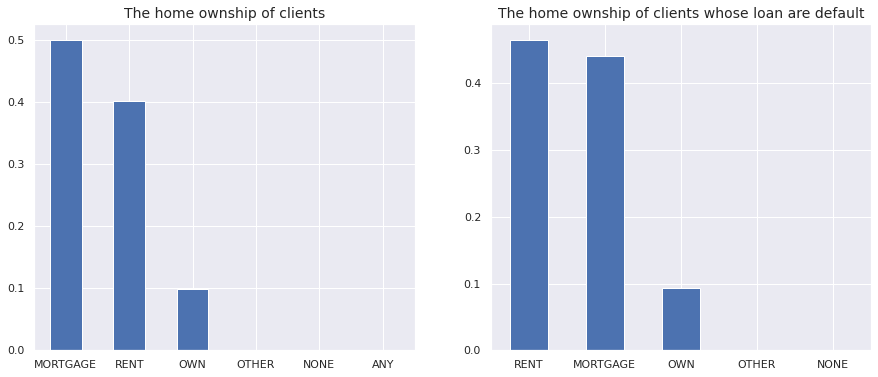

In [ ]:
fig,ax = plt.subplots(1,2)

loan['home_ownership'].value_counts(normalize=True).plot.bar(figsize=(15,6),ax=ax[0])
ax[0].set_xticklabels(labels=loan['home_ownership'].value_counts().index  ,rotation=0)
ax[0].set_title("The home ownship of clients",fontsize=14)


non_performing_l['home_ownership'].value_counts(normalize=True).plot.bar(figsize=(15,6),ax=ax[1])
ax[1].set_xticklabels(labels=non_performing_l['home_ownership'].value_counts().index ,rotation=0)
ax[1].set_title("The home ownship of clients whose loan are default",fontsize=14)

plt.show()

Rent and mortage have higher risk than own. The reason may be they can not borrow money from bank because they don't have house or already mortage house to bank. So, they submit loan application to Lending Club so as to sovle their financial problems.

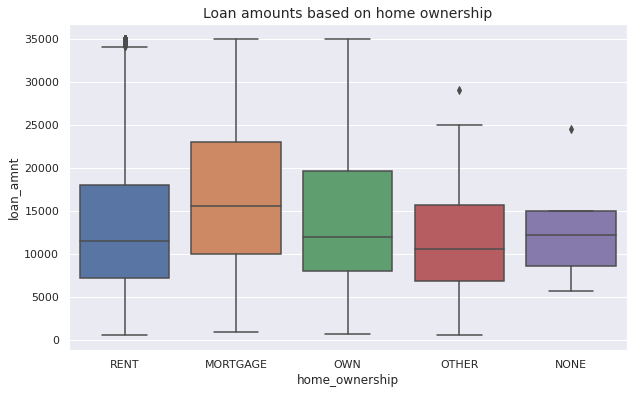

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(y="loan_amnt",x="home_ownership",data=non_performing_l,order=non_performing_l['home_ownership'].value_counts().index)

plt.title("Loan amounts based on home ownership",fontsize=14)
plt.show()

The loan amounts for mortgage and own purpose are higher than others.

### Q3.6: How income will affect the loan status?

### Q3.7: What kind of working years does Lending Club have low risk for lending money?

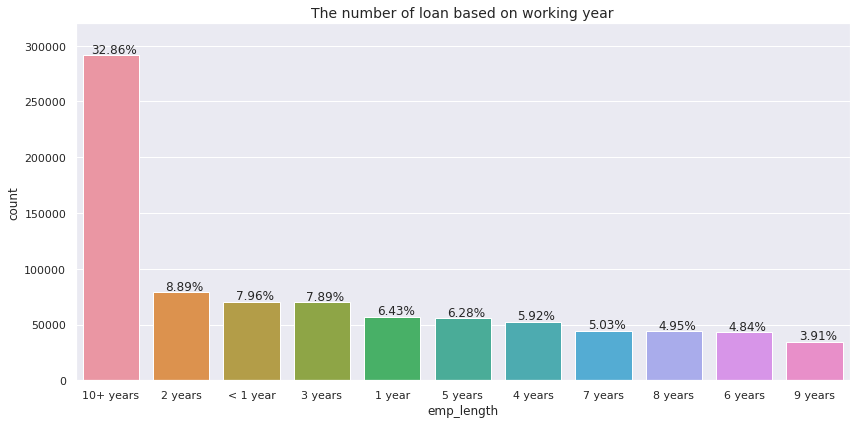

In [ ]:
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'emp_length', data=loan, order=loan['emp_length'].value_counts().index)
for p in g.patches:
  g.text(p.get_x()+p.get_width()/2+0.05, p.get_height()+2000 , f"{p.get_height()/loan.shape[0]*100:2.2f}%",ha="center",fontsize=12)

plt.ylim(0,320000)
plt.title("The number of loan based on working year",fontsize=14)
plt.tight_layout()
plt.show()

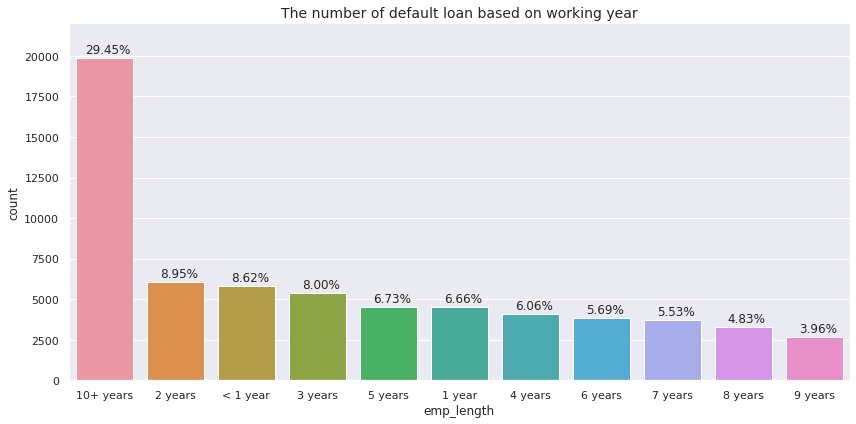

In [ ]:
plt.figure(figsize=(12,6))
g = sns.countplot(x = 'emp_length', data=non_performing_l, order=non_performing_l['emp_length'].value_counts().index)
for p in g.patches:
  g.text(p.get_x()+p.get_width()/2+0.05, p.get_height() +300 , f"{p.get_height()/non_performing_l.shape[0]*100:2.2f}%",ha="center",fontsize=12)

plt.ylim(0,22000)
plt.title("The number of default loan based on working year",fontsize=14)
plt.tight_layout()
plt.show()

Most default loans were found in 10+ years group. But we can't draw a conclusion that 10+ year is a risk factor because this group has the largest proportion in loan applicants.

## Q4: The analysis of risk controling model

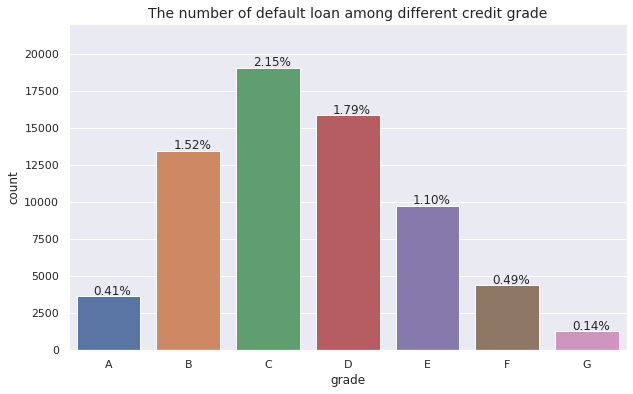

In [ ]:
non_performing_l.sort_values("grade",inplace=True)

plt.figure(figsize=(10,6))
g = sns.countplot("grade",data=non_performing_l)
for p in g.patches:
  g.text(p.get_x()+p.get_width()/2+0.05, p.get_height()+100 , f"{p.get_height()/loan.shape[0]*100:2.2f}%",ha="center",fontsize=12)

g.set_ylim(0, 22000)
g.set_xticklabels(g.get_xticklabels() ,rotation=0)


plt.title("The number of default loan among different credit grade",fontsize=14)
plt.show()

- It is very interesting that the number of default loan don't have positive correlationship with grades. "G" have the least number of default loan. It is possible that risk model of Lending Club reject most "G" grade clients. That's why default loan ratio begin to decrease after 2012.
- It is reasonale that "A" has the low default loan ratio. However, it is uncommon that "C" and "D" have so many clients who cannot afford loan. So, that's what Lending Club need to improve so as to lower default loan ratio.

# Task 2: Feature Engineering

After checking Lending Club data dictionary, the following features were selected for prediction model.
- **loan_amnt**: loan amount($)
- **term**: The number of payments on the loan. Values are in months and can be either 36 or 60.
- **int_rate**: Interest Rate on the loan
- **installment**: The monthly payment owed by the borrower if the loan originates.
- **grade**: Lending Club assigned loan grade
- **emp_length**: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- **home_ownership**: The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER.
- **annual_inc** : The self-reported annual income provided by the borrower during registration.
- **is_inc_v**: Indicates if income was verified by LC, not verified, or if the income source was verified
- **loan_status**: Current status of the loan
- **purpose**: A category provided by the borrower for the loan request. 
- **addr_state**: The state provided by the borrower in the loan application
- **dti**: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- **delinq_2yrs**: The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- **inq_last_6mths**: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- **chargeoff_within_12_mths**: Number of charge-offs within 12 months
- **acc_now_delinq**: The number of accounts on which the borrower is now delinquent.

## 2.1 Select the the following columns to train ML model

In [ ]:
selected_cols = ['loan_amnt',
 'loan_condition',             
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'loan_status',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 #'chargeoff_within_12_mths',
 'acc_now_delinq']

 
loan = loan[selected_cols]

In [ ]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   loan_amnt            887379 non-null  float64
 1   loan_condition       887379 non-null  object 
 2   term                 887379 non-null  object 
 3   int_rate             887379 non-null  float64
 4   installment          887379 non-null  float64
 5   grade                887379 non-null  object 
 6   emp_length           842554 non-null  object 
 7   home_ownership       887379 non-null  object 
 8   annual_inc           887375 non-null  float64
 9   verification_status  887379 non-null  object 
 10  loan_status          887379 non-null  object 
 11  purpose              887379 non-null  object 
 12  addr_state           887379 non-null  object 
 13  dti                  887379 non-null  float64
 14  delinq_2yrs          887350 non-null  float64
 15  inq_last_6mths   

## 2.2 Process missing values

In [ ]:
loan.isnull().sum().sort_values(ascending=False)

emp_length             44825
acc_now_delinq            29
inq_last_6mths            29
delinq_2yrs               29
annual_inc                 4
purpose                    0
loan_status                0
verification_status        0
addr_state                 0
home_ownership             0
dti                        0
grade                      0
installment                0
int_rate                   0
term                       0
loan_condition             0
loan_amnt                  0
dtype: int64

In [ ]:
loan.dropna(inplace=True)

## 2.3 Check the outliers

In [ ]:
loan.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,acc_now_delinq
count,842525.000000,842525.000000,842525.000000,8.425250e+05,842525.000000,842525.000000,842525.000000,842525.000000
mean,14914.081570,13.245270,440.746370,7.635348e+04,18.059022,0.317343,0.696233,0.005010
std,8450.214085,4.385819,244.659742,6.564287e+04,8.278452,0.866137,1.000619,0.077801
min,500.000000,5.320000,15.670000,1.896000e+03,0.000000,0.000000,0.000000,0.000000
25%,8325.000000,9.990000,263.930000,4.700000e+04,11.870000,0.000000,0.000000,0.000000
50%,13200.000000,12.990000,386.720000,6.500000e+04,17.580000,0.000000,0.000000,0.000000
75%,20000.000000,16.200000,577.460000,9.000000e+04,23.830000,0.000000,1.000000,0.000000
max,35000.000000,28.990000,1445.460000,9.500000e+06,380.530000,39.000000,33.000000,14.000000


There is no outliers

## 2.4 Transform categorical features to 0/1 using one-hot encoding

In [ ]:
# term
loan['term'] = loan['term'].map({" 36 months":0, " 60 months":1})

In [ ]:
grade_df = pd.get_dummies(loan['grade'],prefix="grade",drop_first=True)
loan = pd.concat([loan,grade_df],axis=1)
loan.drop("grade",axis=1,inplace=True)
del grade_df; gc.collect()

em_df = pd.get_dummies(loan['emp_length'],prefix="em",drop_first=True)
loan = pd.concat([loan,em_df],axis=1)
loan.drop("emp_length",axis=1,inplace=True)
del em_df;gc.collect()

home_df = pd.get_dummies(loan['home_ownership'],prefix="home",drop_first=True)
loan = pd.concat([loan,home_df],axis=1)
loan.drop("home_ownership",axis=1,inplace=True)
del home_df;gc.collect()

v_df = pd.get_dummies(loan['verification_status'],prefix="veri",drop_first=True)
loan = pd.concat([loan,v_df],axis=1)
loan.drop("verification_status",axis=1,inplace=True)
del v_df;gc.collect()

v_df = pd.get_dummies(loan['purpose'],prefix="purpose",drop_first=True)
loan = pd.concat([loan,v_df],axis=1)
loan.drop("purpose",axis=1,inplace=True)
del v_df;gc.collect()

v_df = pd.get_dummies(loan['addr_state'],prefix="state",drop_first=True)
loan = pd.concat([loan,v_df],axis=1)
loan.drop("addr_state",axis=1,inplace=True)
del v_df;gc.collect()

0

# Task 3:Classification Model --- Loan Status

## 1. Data preprocessing & features selection

In [ ]:
# Generate target variable: "loan_condition"
loan['loan_condition'] = loan['loan_condition'].apply(lambda x:1 if x == "non-performing" else 0)
loan.drop(['loan_status'],inplace=True,axis=1)

# Generate the correlation matrix and select "loan_condition" column
correlation_df = loan.corr()['loan_condition'].sort_values(ascending=False)
correlation_df

loan_condition          1.000000
int_rate                0.177096
inq_last_6mths          0.081193
grade_F                 0.071269
grade_E                 0.069933
                          ...   
veri_Source Verified   -0.022478
annual_inc             -0.033752
home_MORTGAGE          -0.033931
purpose_credit_card    -0.040282
grade_B                -0.056295
Name: loan_condition, Length: 96, dtype: float64

In [ ]:
# Filter the variables whose correlation is above 0.01
cols = correlation_df[(correlation_df>0.01)&(correlation_df!=1) ].index.tolist()
cols

['int_rate',
 'inq_last_6mths',
 'grade_F',
 'grade_E',
 'grade_D',
 'veri_Verified',
 'grade_G',
 'term',
 'purpose_small_business',
 'home_RENT',
 'dti',
 'purpose_other',
 'purpose_debt_consolidation',
 'installment',
 'em_6 years',
 'purpose_educational',
 'state_NY']

In [ ]:
from sklearn.preprocessing import minmax_scale
loan[['loan_amnt',"annual_inc","installment","dti"]] = minmax_scale(loan[['int_rate',"inq_last_6mths","installment","dti"]])
loan.head()

,loan_amnt,loan_condition,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,acc_now_delinq,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,em_10+ years,em_2 years,em_3 years,em_4 years,em_5 years,em_6 years,em_7 years,em_8 years,em_9 years,em_< 1 year,home_MORTGAGE,home_NONE,home_OTHER,home_OWN,home_RENT,veri_Source Verified,veri_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,...,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0.280946,1,0,11.97,0.126620,0.515152,0.054766,0.0,17.0,0.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.214195,0,0,10.39,0.081529,0.000000,0.024413,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.280946,0,0,11.97,0.083663,0.060606,0.038341,0.0,2.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.099704,0,0,7.68,0.032669,0.000000,0.030116,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.227714,1,0,10.71,0.070563,0.030303,0.034951,0.0,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2. Split dataset into training and testing

In [ ]:
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y = train_test_split(loan[cols],loan['loan_condition'],test_size=0.2)

## 3. Define the evaluation methods

In [ ]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

# Helper method to print metric scores    
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
  metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
  metric_values_train = [roc_auc_score(y_train, y_train_pred),
                  accuracy_score(y_train, y_train_pred>threshold),
                  precision_score(y_train, y_train_pred>threshold),
                  recall_score(y_train, y_train_pred>threshold),
                  f1_score(y_train, y_train_pred>threshold)
                  ]
  metric_values_test = [roc_auc_score(y_test, y_test_pred),
                  accuracy_score(y_test, y_test_pred>threshold),
                  precision_score(y_test, y_test_pred>threshold),
                  recall_score(y_test, y_test_pred>threshold),
                  f1_score(y_test, y_test_pred>threshold)
                  ]
  all_metrics = pd.DataFrame({'metrics':metric_names,
                              'train':metric_values_train,
                              'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
  print(all_metrics)

In [ ]:
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
  roc_auc_train = roc_auc_score(y_train, y_train_pred)
  fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

  roc_auc_test = roc_auc_score(y_test, y_test_pred)
  fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
  plt.figure()
  lw = 2
  plt.plot(fpr_train, tpr_train, color='green',
            lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
  plt.plot(fpr_test, tpr_test, color='darkorange',
            lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
def train_test_model(clf, X_train, y_train, X_test, y_test):
  # Fit a model by providing X and y from training set
  clf.fit(X_train, y_train)

  # Make prediction on the training data
  y_train_pred = clf.predict(X_train)
  p_train_pred = clf.predict_proba(X_train)[:,1]

  # Make predictions on test data
  y_test_pred = clf.predict(X_test)
  p_test_pred = clf.predict_proba(X_test)[:,1]

  # print model results
  get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
  plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

## 4. Machline learning modeling

- Logistic Regression
- Decision Tree
- Random Forest
- Naive Bayes
- Gradient Boosting Tree
- Multilayer Perceptron

### a. Logistic Regression (AUC: 69.34%)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              train      test
metrics                      
AUC        0.701712  0.699570
Accuracy   0.924352  0.924406
Precision  0.235294  0.333333
Recall     0.000078  0.000079
f1-score   0.000157  0.000157


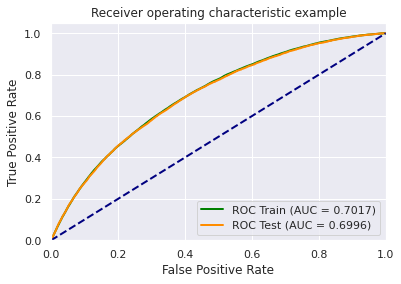

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_m = LogisticRegression(random_state=101)
train_test_model(lr_m,train_X,train_y,test_X,test_y)

### b. Decision Tree (AUC: 72.55%)

              train      test
metrics                      
AUC        0.738914  0.725573
Accuracy   0.925044  0.923943
Precision  0.800263  0.295337
Recall     0.011946  0.004475
f1-score   0.023541  0.008817


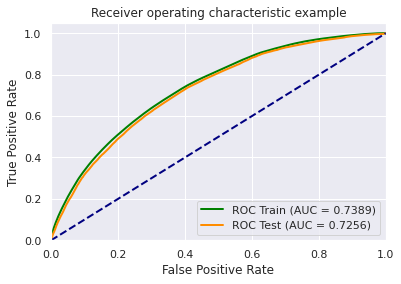

In [ ]:
from sklearn.tree import DecisionTreeClassifier


dt_m = DecisionTreeClassifier(max_depth=10,)
train_test_model(dt_m,train_X,train_y,test_X,test_y)

### c. Random Forest (AUC: 73.08%)

              train      test
metrics                      
AUC        0.816488  0.730837
Accuracy   0.926628  0.924382
Precision  1.000000  0.259259
Recall     0.030066  0.000550
f1-score   0.058378  0.001098


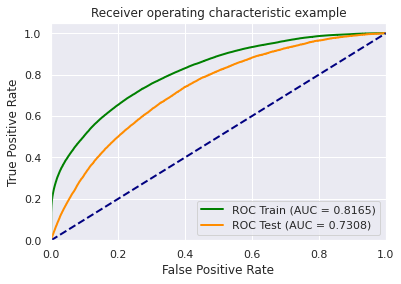

CPU times: user 3min 40s, sys: 619 ms, total: 3min 41s
Wall time: 1min 53s


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf_m = RandomForestClassifier(max_depth=16,n_jobs=4,)
train_test_model(rf_m,train_X,train_y,test_X,test_y)

### d. Navie Bayes (AUC:67.53%)

              train      test
metrics                      
AUC        0.671970  0.675362
Accuracy   0.884425  0.885327
Precision  0.183741  0.184799
Recall     0.153333  0.151858
f1-score   0.167166  0.166717


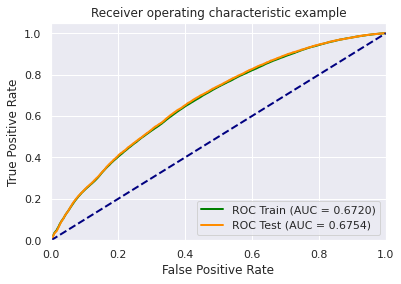

In [ ]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
train_test_model(gnb_m,train_X,train_y,test_X,test_y)

### e.Gradient Boosting Tree (AUC: 74.43%)

              train      test
metrics                      
AUC        0.823921  0.744384
Accuracy   0.927698  0.923539
Precision  0.996476  0.250804
Recall     0.044364  0.006128
f1-score   0.084947  0.011963


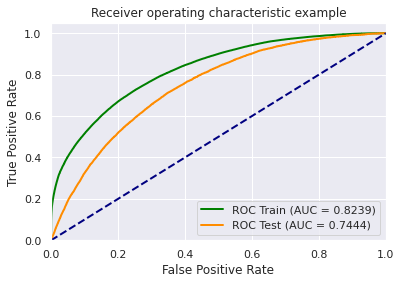

CPU times: user 6min 32s, sys: 576 ms, total: 6min 33s
Wall time: 6min 33s


In [ ]:
%%time
from sklearn.ensemble import GradientBoostingClassifier

gbdt_m = GradientBoostingClassifier(learning_rate=0.1,max_depth=10)
train_test_model(gbdt_m, train_X,train_y,test_X,test_y)

### f. Multilayer Perceptron

Iteration 1, loss = 0.27147329
Iteration 2, loss = 0.25546064
Iteration 3, loss = 0.25268269
Iteration 4, loss = 0.25160514
Iteration 5, loss = 0.25125713
Iteration 6, loss = 0.25106060
Iteration 7, loss = 0.25073323
Iteration 8, loss = 0.25067968
Iteration 9, loss = 0.25049199
Iteration 10, loss = 0.25035853
Iteration 11, loss = 0.25047983
Iteration 12, loss = 0.25047445
Iteration 13, loss = 0.25037564
Iteration 14, loss = 0.25036215
Iteration 15, loss = 0.25036154
Iteration 16, loss = 0.25043035
Iteration 17, loss = 0.25025993
Iteration 18, loss = 0.25052174
Iteration 19, loss = 0.25018523
Iteration 20, loss = 0.25019613
Iteration 21, loss = 0.25012738
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              train      test
metrics                      
AUC        0.703818  0.705938
Accuracy   0.924352  0.924459
Precision  0.000000  0.000000
Recall     0.000000  0.000000
f1-score   0.000000  0.000000


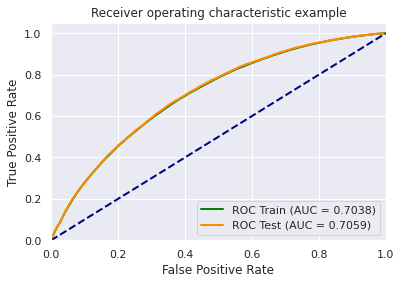

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_m = MLPClassifier(verbose=True,hidden_layer_sizes=(16,16),activation="logistic")
train_test_model(mlp_m,train_X,train_y,test_X,test_y)

## 4. Conclusion

In [ ]:
c_result = pd.DataFrame(data={
    "Methods":["Logistic Regression", "Decision Tree", "Random Forest", "Navie Bayes", "*Gradient Boosting*", "Multilayer Perceptron"],
    "AUC":["69.34%", "72.55%", "73.08%","67.53%","74.43%","70.59%"]
}).set_index("Methods")
c_result

,AUC
Methods,
Logistic Regression,69.34%
Decision Tree,72.55%
Random Forest,73.08%
Navie Bayes,67.53%
*Gradient Boosting*,74.43%
Multilayer Perceptron,70.59%


# Task 4:Regression Model --- Default Rate Prediction

## 1.Data preprocessing

In [ ]:
from sklearn.preprocessing import minmax_scale

loan = loan.drop("loan_status",axis=1)

loan[['loan_amnt',"annual_inc","installment","dti"]] = minmax_scale(loan[['loan_amnt',"annual_inc","installment","dti"]])

loan['loan_condition'] = np.where(loan['loan_condition']=="performing",1,0)
loan.head()

## 2. Features selection

In [ ]:
int_corr = loan.corr()['int_rate'].sort_values(ascending=False)
int_corr

int_rate               1.000000
grade_E                0.446712
term                   0.433081
grade_D                0.386153
grade_F                0.385700
                         ...   
state_MA              -0.020654
home_MORTGAGE         -0.060965
annual_inc            -0.072624
purpose_credit_card   -0.184825
grade_B               -0.348951
Name: int_rate, Length: 96, dtype: float64

In [ ]:
regression_cols = int_corr[(int_corr>=0.01) & (int_corr!=1.0)].index.tolist()
regression_cols

['grade_E',
 'term',
 'grade_D',
 'grade_F',
 'inq_last_6mths',
 'grade_G',
 'veri_Verified',
 'dti',
 'loan_amnt',
 'installment',
 'grade_C',
 'purpose_debt_consolidation',
 'purpose_other',
 'purpose_small_business',
 'home_RENT',
 'delinq_2yrs',
 'purpose_moving',
 'purpose_house',
 'purpose_medical',
 'acc_now_delinq',
 'purpose_vacation',
 'state_AL',
 'purpose_renewable_energy',
 'em_7 years',
 'state_HI',
 'purpose_wedding']

## 3. Split data into training and testing

In [ ]:
from sklearn.model_selection import train_test_split

train_X,test_X,train_y,test_y = train_test_split(loan[regression_cols],loan['int_rate'],test_size=0.2)

## 4. Define evaluation function

Mean squared error, R2 square

In [ ]:
def train_test_reg(clf,X_train,y_train,X_test,y_test):
  clf.fit(X_train, y_train)

  y_val = clf.predict(X_train)
  y_pred = clf.predict(X_test)

  all_metrics = pd.DataFrame(
      data= {"Dataset":["training", "Testing" ],
          "Mean Squared Error": [mean_squared_error(y_train,y_val),mean_squared_error(y_test,y_pred)],
          "R2 Score": [r2_score(y_train,y_val),r2_score(y_test,y_pred)] }

  ).set_index("Dataset")
  print(all_metrics)

## 5. Machine Learning

### a. Linear Regression (MSE: 2.68)

In [ ]:
from sklearn.linear_model import LinearRegression

train_test_reg(LinearRegression(),train_X,train_y,test_X,test_y)

          Mean Squared Error  R2 Score
Dataset                               
training            2.667324  0.861321
Testing             2.682408  0.860593


### b. Decision Tree (MSE: 0.157)

In [ ]:
from sklearn.tree import DecisionTreeRegressor

train_test_reg(DecisionTreeRegressor(max_depth=60),train_X,train_y,test_X,test_y)

          Mean Squared Error  R2 Score
Dataset                               
training            0.000002  1.000000
Testing             0.157413  0.991819


### c. Random Forest (MSE: 0.086)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

train_test_reg(RandomForestRegressor(),train_X,train_y,test_X,test_y)

          Mean Squared Error  R2 Score
Dataset                               
training            0.012207  0.999365
Testing             0.085891  0.995536


### d.Gradient Boosting (MSE:0.062)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


train_test_reg(GradientBoostingRegressor(max_depth=20),train_X,train_y,test_X,test_y)

          Mean Squared Error  R2 Score
Dataset                               
training            0.002421  0.999874
Testing             0.062538  0.996750


## 6. Conclusion

In [ ]:
reg_metric = pd.DataFrame(data = {
    "Methods": [ "Linear Regression", "Decision Tree", "Random Forest", "*Gradient Boosting*"],
    "MSE":[2.68,0.157, 0.086, 0.062 ],
    "R2 score": [0.8606,0.9918,0.9955,0.9968]
}).set_index("Methods")
reg_metric

,MSE,R2 score
Methods,,
Linear Regression,2.680,0.8606
Decision Tree,0.157,0.9918
Random Forest,0.086,0.9955
*Gradient Boosting*,0.062,0.9968
